import tempfile
from urllib.request import urlretrieve
import sys
import shutil
from distutils.dir_util import copy_tree
import os

from google.colab import drive,files
drive.mount('/content/drive')
os.makedirs("/content/5lsl0_MLSP")
ROOT_DIR = "/content/5lsl0_MLSP"
copy_tree("/content/5lsl0_MLSP","/content/drive/TUe/5lsl0_MLSP")

In [1]:
from Fast_MRI_dataloader import create_dataloaders
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

In [94]:
ROOT_DIR = os.path.abspath('.')
data_loc = os.path.join(ROOT_DIR,"Fast_MRI_Knee")
fig_loc = os.path.join(ROOT_DIR,"figure")
batch_size = 5
train_loader, test_loader = create_dataloaders(data_loc,batch_size)
if os.path.exists(fig_loc):
    pass
else:
    os.makedirs(fig_loc)


### Exercise 3a) K-space using torch.fft.fft2

In [95]:
def kspace(img):
    out = torch.fft.fft2(img)
    for i in range(len(out)):
        out[i] = torch.fft.fftshift(out[i])
    return out

In [96]:
kp,m,gt = next(iter(test_loader))
gt_kspace = kspace(gt)

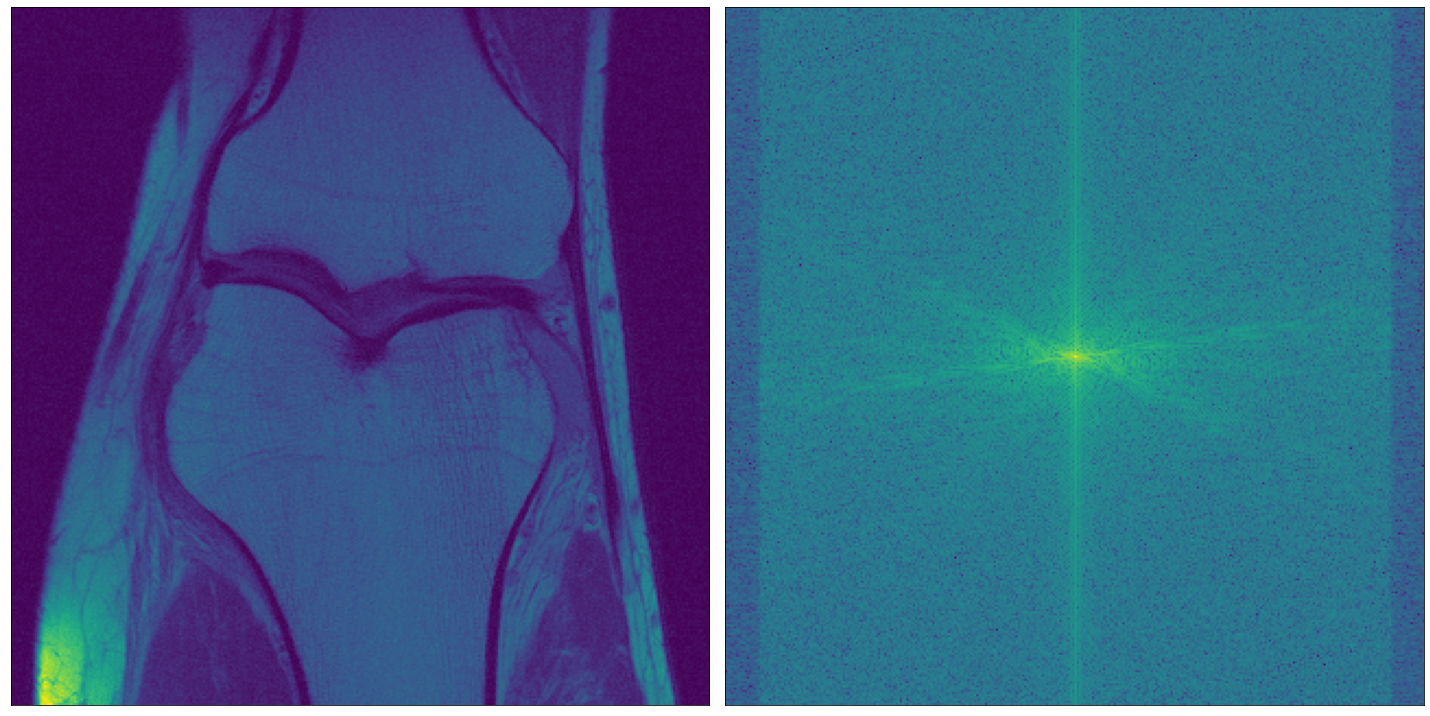

In [97]:
kp,m,gt = next(iter(test_loader))
gt_kspace = kspace(gt)
gt_kspace_plt = torch.log(torch.abs(gt_kspace))
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(gt[1,:,:])
plt.xticks([])
plt.yticks([])
plt.subplot(1,2,2)
plt.imshow(gt_kspace_plt[1,:,:])
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.savefig(os.path.join(fig_loc,"w2e3q1.png"),dpi=80,bbox_inches='tight')
plt.show()


### Exercise 3b) partial k-space

In [98]:
def partial(img_fft,mask):
    return torch.mul(img_fft,mask)
def re_kspace(p_kspace):
    out = torch.zeros_like(p_kspace)
    for i in range(len(p_kspace)):
        out[i] = torch.fft.ifftshift(p_kspace[i])
    return torch.fft.ifft2(out)

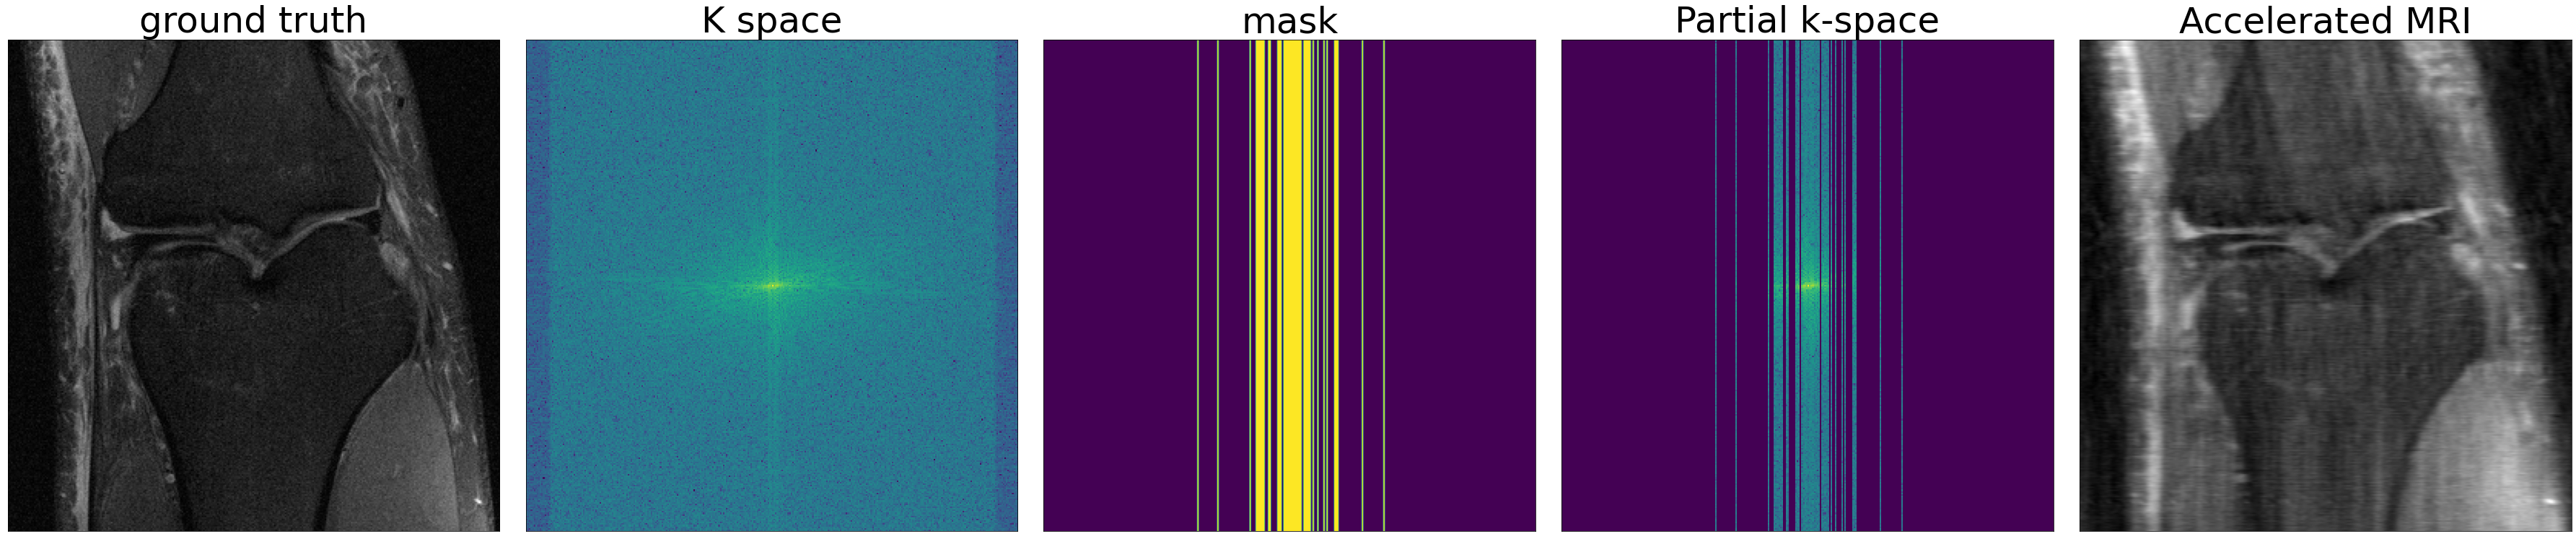

In [99]:
kp,m,gt = next(iter(test_loader))
gt_kspace = kspace(gt)
gt_p_k_space = partial(gt_kspace,m)
gt_re = re_kspace(gt_p_k_space)

gt_kspace_plt = torch.log(torch.abs(gt_kspace))
gt_p_k_space_plt = torch.log(torch.abs(gt_p_k_space)+1e-4)
gt_re_plt = torch.abs(gt_re)
v_min = torch.min(gt_kspace_plt[1,:,:])-0.1
v_max = torch.max(gt_kspace_plt[1,:,:])+0.1

plt.figure(figsize=(50,10))

plt.subplot(1,5,1)
plt.imshow(gt[1,:,:],cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title("ground truth",fontsize=50)

plt.subplot(1,5,2)
plt.imshow(gt_kspace_plt[1,:,:],vmin=v_min,vmax=v_max,interpolation='nearest')
plt.xticks([])
plt.yticks([])
plt.title("K space",fontsize=50)

plt.subplot(1,5,3)
plt.imshow(m[1,:,:])
plt.xticks([])
plt.yticks([])
plt.title("mask",fontsize=50)

plt.subplot(1,5,4)
plt.imshow(gt_p_k_space_plt[1,:,:],vmin=v_min,vmax=v_max,interpolation='nearest')
plt.xticks([])
plt.yticks([])
plt.title("Partial k-space",fontsize=50)

plt.subplot(1,5,5)
plt.imshow(gt_re_plt[1,:,:],cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title("Accelerated MRI",fontsize=50)


plt.tight_layout()
plt.savefig(os.path.join(fig_loc,"w2e3q4.png"),dpi=80,bbox_inches='tight')
plt.show()

### Exercise 3e) What is this effect called? This is because the mask is vertical lines?

## Exercise 4 ISTA for accelerated MRI 

In [136]:
def softthreshold(x,shrinkage):
    temp1 = torch.abs(x)-shrinkage
    temp2 = torch.zeros_like(temp1)
    temp3 =torch.max(temp1,temp2)
    # print(temp)
    return torch.multiply(torch.sgn(x),temp3)


def ISTA_MRI(mu,lambd,k,y:torch.tensor,m:torch.tensor)->torch.tensor:
    """
    INPUT:
    mu:     step size               (float32)
    lambd:  shrinkage parameter     (float32)
    k:      number of iteration     (int)
    y:      k-space measurements    (tensor)
    m:      mask                    (tensor)
    -----------------------------------------
    recons: reconstruction          (tensor)
    """
    x_1 = torch.zeros_like(y)
    for i in range(k):
        g_1 = torch.mul(m,y-torch.mul(m,x_1))
        x_2 = x_1 + mu * g_1
        x_hat = softthreshold(x_2,lambd*mu)
        # x_hat = torch.tanh(x_hat)
        error = torch.nn.functional.mse_loss(torch.abs(x_hat),torch.abs(x_1))
        if error < 1e-15:
            break
        else:
            x_1 = x_hat
    recons = x_hat
    # return recons, x_hat, error,i
    return recons,i



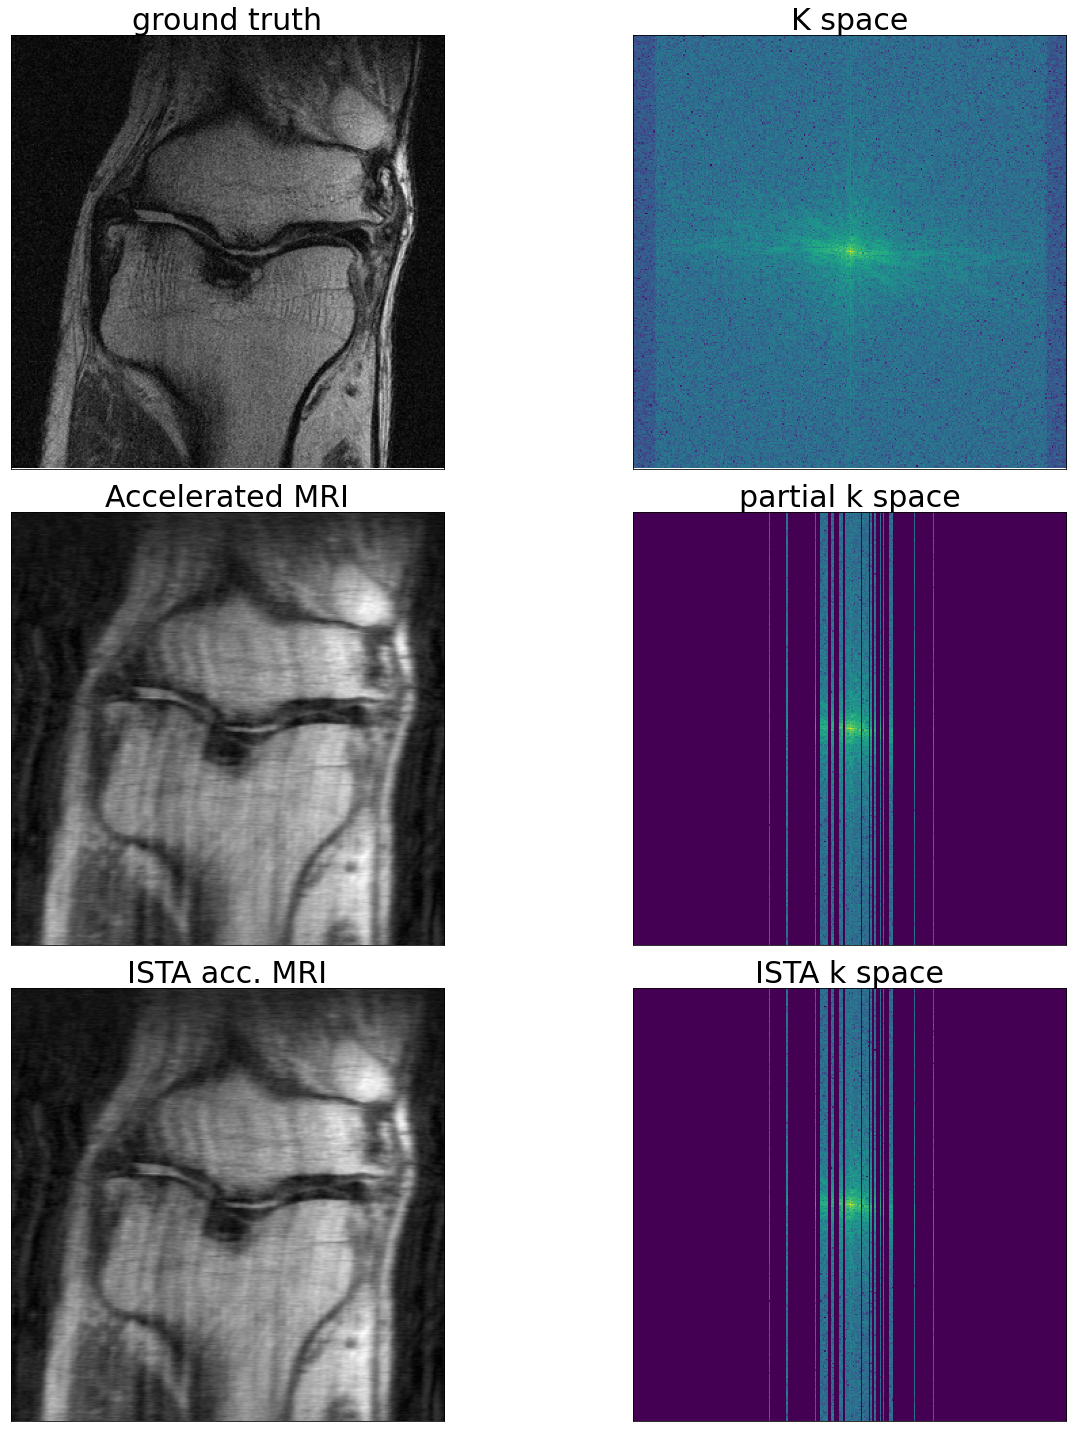

999


In [137]:
kp,m,gt = next(iter(test_loader))
gt_kspace = kspace(gt)
gt_p_k_space = partial(gt_kspace,m)
gt_re = re_kspace(gt_p_k_space)

gt_kspace_plt = torch.log(torch.abs(gt_kspace))
gt_p_k_space_plt = torch.log(torch.abs(gt_p_k_space)+1e-4)
gt_re_plt = torch.abs(gt_re)
v_min = torch.min(gt_kspace_plt[1,:,:])-0.1
v_max = torch.max(gt_kspace_plt[1,:,:])+0.1


mu = 0.5
lambd = 1
k = 1000
gt_ISTA_k_space,i = ISTA_MRI(mu,lambd,k,kp[1,:,:],m[1,:,:])
gt_ISTA_re = re_kspace(gt_ISTA_k_space)
gt_ISTA_k_space_plt = torch.log(torch.abs(gt_ISTA_k_space)+1e-4)
gt_ISTA_re_plt = torch.abs(gt_ISTA_re)
plt.figure(figsize=(20,20))
plt.subplot(3,2,1)
plt.imshow(gt[1,:,:],cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title("ground truth",fontsize=30)
plt.subplot(3,2,2)
plt.imshow(gt_kspace_plt[1,:,:],vmin=v_min,vmax=v_max,interpolation='nearest')
plt.xticks([])
plt.yticks([])
plt.title("K space",fontsize=30)
plt.subplot(3,2,4)
plt.imshow(gt_p_k_space_plt[1,:,:],vmin=v_min,vmax=v_max,interpolation='nearest')
plt.xticks([])
plt.yticks([])
plt.title("partial k space",fontsize=30)
plt.subplot(3,2,3)
plt.imshow(gt_re_plt[1,:,:],cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title("Accelerated MRI",fontsize=30)
plt.subplot(3,2,6)
plt.imshow(gt_ISTA_k_space_plt,vmin=v_min,vmax=v_max,interpolation='nearest')
plt.xticks([])
plt.yticks([])
plt.title("ISTA k space",fontsize=30)
plt.subplot(3,2,5)
plt.imshow(gt_ISTA_re_plt,cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title("ISTA acc. MRI",fontsize=30)
plt.tight_layout()
# plt.savefig(os.path.join(fig_loc,"w2e4q4.png"),dpi=80,bbox_inches='tight')
plt.show()
print(i)

data consistency step for ISTA MRI:    $X-\mu M\odot( M \odot  X) + \mu M\odot Y $

In [139]:
import sys
from tqdm import tqdm
import torch.nn.functional as F

MSE=0
for batch_idx,(kp,m,gt) in enumerate(tqdm(test_loader,colour='green')):
    gt_ISTA_k_space,_ = ISTA_MRI(mu,lambd,k,kp,m)
    gt_ISTA_re = torch.abs(re_kspace(gt_ISTA_k_space))
    MSE += F.mse_loss(gt,gt_ISTA_re)

print(f'MSE over whole test set is {MSE/(batch_idx+1)}')
    
    

 63%|██████▎   | 31/49 [09:02<05:04, 16.90s/it]

In [ ]:
mu = 0.5
lambd = 0.9
k = 1000

kp,m,gt = next(iter(test_loader))
gt_kspace = kspace(gt)
gt_p_k_space = partial(gt_kspace,m)
gt_re = re_kspace(gt_p_k_space)

gt_kspace_plt = torch.log(torch.abs(gt_kspace))
gt_p_k_space_plt = torch.log(torch.abs(gt_p_k_space)+1e-4)
gt_re_plt = torch.abs(gt_re)
v_min = torch.min(gt_kspace_plt[1,:,:])-0.1
v_max = torch.max(gt_kspace_plt[1,:,:])+0.1

plt.figure(figsize=(30,50))

plt.subplot(1,5,1)
plt.imshow(gt[1,:,:],cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title("ground truth",fontsize=50)

plt.subplot(1,5,2)
plt.imshow(gt_kspace_plt[1,:,:],vmin=v_min,vmax=v_max,interpolation='nearest')
plt.xticks([])
plt.yticks([])
plt.title("K space",fontsize=50)

plt.subplot(1,5,3)
plt.imshow(m[1,:,:])
plt.xticks([])
plt.yticks([])
plt.title("mask",fontsize=50)

plt.subplot(1,5,4)
plt.imshow(gt_p_k_space_plt[1,:,:],vmin=v_min,vmax=v_max,interpolation='nearest')
plt.xticks([])
plt.yticks([])
plt.title("Partial k-space",fontsize=50)

plt.subplot(1,5,5)
plt.imshow(gt_re_plt[1,:,:],cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title("Accelerated MRI",fontsize=50)


plt.tight_layout()
plt.savefig(os.path.join(fig_loc,"w2e4q4.png"),dpi=80,bbox_inches='tight')
plt.show()